In [1]:
import os
from typing import List, Dict
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import lightgbm as lgb
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib
import matplotlib.pyplot as plt

In [2]:
data_path: str = "/data/ephemeral/home/BTC/data"
train_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "train.csv")).assign(_type="train") # train 에는 _type = train 
test_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv")).assign(_type="test") # test 에는 _type = test
submission_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv")) # ID, target 열만 가진 데이터 미리 호출
df: pd.DataFrame = pd.concat([train_df, test_df], axis=0)

In [3]:
# HOURLY_ 로 시작하는 .csv 파일 이름을 file_names 에 할딩
file_names: List[str] = [
    f for f in os.listdir(data_path) if f.startswith("HOURLY_") and f.endswith(".csv")
]

# 파일명 : 데이터프레임으로 딕셔너리 형태로 저장
file_dict: Dict[str, pd.DataFrame] = {
    f.replace(".csv", ""): pd.read_csv(os.path.join(data_path, f)) for f in file_names
}

for _file_name, _df in tqdm(file_dict.items()):
    # 열 이름 중복 방지를 위해 {_file_name.lower()}_{col.lower()}로 변경, datetime 열을 ID로 변경
    _rename_rule = {
        col: f"{_file_name.lower()}_{col.lower()}" if col != "datetime" else "ID"
        for col in _df.columns
    }
    _df = _df.rename(_rename_rule, axis=1)
    df = df.merge(_df, on="ID", how="left")


100%|██████████| 107/107 [00:03<00:00, 28.95it/s]


In [4]:
eda_df = df.loc[df["_type"] == "train"]
eda_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8760 entries, 0 to 8759
Columns: 255 entries, ID to hourly_market-data_open-interest_okx_btc_usdt_open_interest
dtypes: float64(250), int64(3), object(2)
memory usage: 17.1+ MB


In [5]:
# column 추출
# taker_buy_sell_volume: ratio data 제외
# fees: total 제외
# tokens-transferred, transactions-count: total 제외
cols_dict: Dict[str, str] = {
    "ID": "ID",
    "target": "target",
    "hourly_market-data_coinbase-premium-index_coinbase_premium_gap": "coinbase_premium_gap",
    "hourly_market-data_coinbase-premium-index_coinbase_premium_index": "coinbase_premium_index",
    "hourly_market-data_liquidations_all_exchange_all_symbol_long_liquidations": "long_liquidations",
    "hourly_market-data_liquidations_all_exchange_all_symbol_short_liquidations": "short_liquidations",
    "hourly_market-data_liquidations_all_exchange_all_symbol_long_liquidations_usd": "long_liquidations_usd",
    "hourly_market-data_liquidations_all_exchange_all_symbol_short_liquidations_usd": "short_liquidations_usd",
    "hourly_market-data_open-interest_all_exchange_all_symbol_open_interest": "open_interest",
    "hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close": "close",
    "hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_volume": "volume",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_volume": "taker_buy_volume",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_sell_volume": "taker_sell_volume",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_sell_ratio": "taker_buy_sell_ratio",
    "hourly_network-data_addresses-count_addresses_count_active": "addresses_count_active",
    "hourly_network-data_addresses-count_addresses_count_sender": "addresses_count_sender",
    "hourly_network-data_addresses-count_addresses_count_receiver": "addresses_count_receiver",
    "hourly_network-data_block-bytes_block_bytes": "block_bytes",
    "hourly_network-data_block-count_block_count": "block_count",
    "hourly_network-data_block-interval_block_interval": "block_interval",
    "hourly_network-data_blockreward_blockreward": "blockreward",
    "hourly_network-data_blockreward_blockreward_usd": "blockreward_usd",
    "hourly_network-data_difficulty_difficulty": "difficulty",
    "hourly_network-data_fees_fees_block_mean": "fees_block_mean",
    "hourly_network-data_fees_fees_block_mean_usd": "fees_block_mean_usd",
    "hourly_network-data_fees-transaction_fees_transaction_mean": "fees_transaction_mean",
    "hourly_network-data_fees-transaction_fees_transaction_mean_usd": "fees_transaction_mean_usd",
    "hourly_network-data_fees-transaction_fees_transaction_median": "fees_transaction_median",
    "hourly_network-data_fees-transaction_fees_transaction_median_usd": "fees_transaction_median_usd",
    "hourly_network-data_hashrate_hashrate": "hashrate",
    "hourly_network-data_supply_supply_total": "supply_total",
    "hourly_network-data_supply_supply_new": "supply_new",
    "hourly_network-data_tokens-transferred_tokens_transferred_mean": "tokens_transferred_mean",
    "hourly_network-data_tokens-transferred_tokens_transferred_median": "tokens_transferred_median",
    "hourly_network-data_transactions-count_transactions_count_mean": "transactions_count_mean",
    "hourly_network-data_utxo-count_utxo_count": "utxo_count",
    "hourly_network-data_velocity_velocity_supply_total": "velocity_supply_total"
}
# 추출후 단순화를 위해 rename
eda_df = eda_df[cols_dict.keys()].rename(cols_dict, axis=1)

In [6]:
eda_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8760 entries, 0 to 8759
Data columns (total 37 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           8760 non-null   object 
 1   target                       8760 non-null   float64
 2   coinbase_premium_gap         8755 non-null   float64
 3   coinbase_premium_index       8755 non-null   float64
 4   long_liquidations            8760 non-null   float64
 5   short_liquidations           8760 non-null   float64
 6   long_liquidations_usd        8760 non-null   float64
 7   short_liquidations_usd       8760 non-null   float64
 8   open_interest                8760 non-null   float64
 9   close                        8760 non-null   float64
 10  volume                       8760 non-null   float64
 11  taker_buy_volume             8760 non-null   float64
 12  taker_sell_volume            8760 non-null   float64
 13  taker_buy_sell_ratio   

In [7]:
eda_df.columns

Index(['ID', 'target', 'coinbase_premium_gap', 'coinbase_premium_index',
       'long_liquidations', 'short_liquidations', 'long_liquidations_usd',
       'short_liquidations_usd', 'open_interest', 'close', 'volume',
       'taker_buy_volume', 'taker_sell_volume', 'taker_buy_sell_ratio',
       'addresses_count_active', 'addresses_count_sender',
       'addresses_count_receiver', 'block_bytes', 'block_count',
       'block_interval', 'blockreward', 'blockreward_usd', 'difficulty',
       'fees_block_mean', 'fees_block_mean_usd', 'fees_transaction_mean',
       'fees_transaction_mean_usd', 'fees_transaction_median',
       'fees_transaction_median_usd', 'hashrate', 'supply_total', 'supply_new',
       'tokens_transferred_mean', 'tokens_transferred_median',
       'transactions_count_mean', 'utxo_count', 'velocity_supply_total'],
      dtype='object')

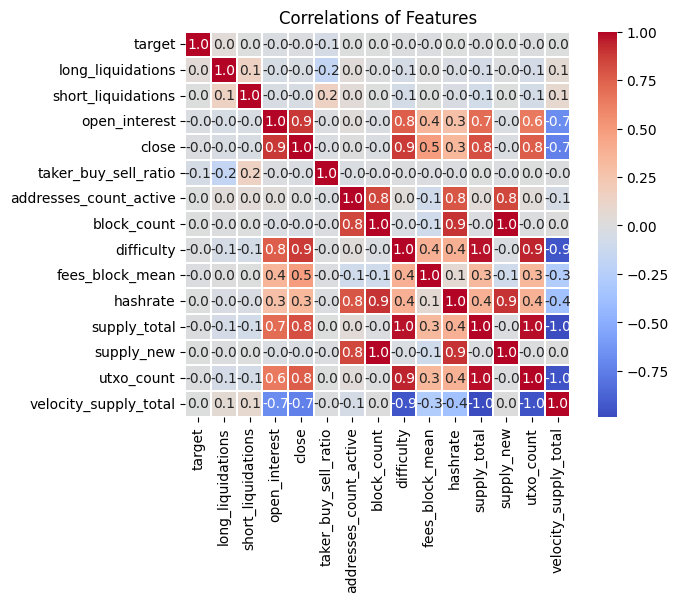

In [8]:
import seaborn as sns

selected_cols = [
    'target',
    'long_liquidations',
    'short_liquidations',
    'open_interest',
    'close',
    'taker_buy_sell_ratio',
    'addresses_count_active',
    'block_count',
    'difficulty',
    'fees_block_mean',
    'hashrate',
    'supply_total',
    'supply_new',
    'utxo_count',
    'velocity_supply_total'
]

selected_df = eda_df.loc[:, selected_cols]
selected_corr_df = selected_df.corr()
plt.figure(figsize=(7, 5))
sns.heatmap(selected_corr_df, cmap='coolwarm', annot=True, fmt='.1f', linewidth=0.2, square=True)
plt.title('Correlations of Features')
plt.show()

(array([ 740.,    0.,    0., 3544.,    0.,    0., 3670.,    0.,    0.,
         806.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

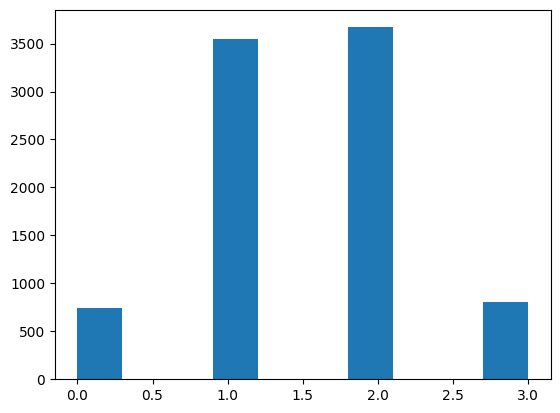

In [9]:
close = pd.DataFrame()
close['close'] = eda_df.loc[:, 'close']
close['close_lag1'] = close['close'].shift(1)
close['close_lag1_percent'] = (close['close'] - close['close_lag1']) / close['close_lag1']
close['class'] = close['close']
for i in range(close.shape[0]):
    if close.loc[i, 'close_lag1_percent'] < -0.005:
        close.loc[i, 'class'] = 0
    elif close.loc[i, 'close_lag1_percent'] < 0:
        close.loc[i, 'class'] = 1
    elif close.loc[i, 'close_lag1_percent'] < 0.005:
        close.loc[i, 'class'] = 2
    else:
        close.loc[i, 'class'] = 3

plt.hist(close['class'])

In [10]:
(close['class'].shift(-1) == eda_df['target']).mean()

0.9998858447488584

In [11]:
eda_df.columns

Index(['ID', 'target', 'coinbase_premium_gap', 'coinbase_premium_index',
       'long_liquidations', 'short_liquidations', 'long_liquidations_usd',
       'short_liquidations_usd', 'open_interest', 'close', 'volume',
       'taker_buy_volume', 'taker_sell_volume', 'taker_buy_sell_ratio',
       'addresses_count_active', 'addresses_count_sender',
       'addresses_count_receiver', 'block_bytes', 'block_count',
       'block_interval', 'blockreward', 'blockreward_usd', 'difficulty',
       'fees_block_mean', 'fees_block_mean_usd', 'fees_transaction_mean',
       'fees_transaction_mean_usd', 'fees_transaction_median',
       'fees_transaction_median_usd', 'hashrate', 'supply_total', 'supply_new',
       'tokens_transferred_mean', 'tokens_transferred_median',
       'transactions_count_mean', 'utxo_count', 'velocity_supply_total'],
      dtype='object')

In [12]:
def double_plot(
    data: pd.DataFrame,
    lefty: str,
    righty: str,
    leftax: matplotlib.axes._axes.Axes,
    rightalpha: float,
    leftlabel: bool=True,
    rightlabel: bool=True
)-> None:
    """twinx를 이용한 비교 차트 생성 함수입니다.

    Args:
        data (pd.DataFrame): 차트를 그릴 데이터프레임
        lefty (str): 왼쪽에 라벨링할 column의 이름
        righty (str): 오른쪽에 라벨링할 column의 이름
        leftax (matplotlib.axes._axes.Axes): 차트를 그릴 축
        rightalpha (float): 오른쪽에 그릴 차트의 alpha 값
        leftlabel (bool): 왼쪽 ylabel을 나타낼지 여부
        rightlabel (bool): 오른쪽 ylabel을 나타낼지 여부
    
    Returns:
        None
    """

    leftax.plot(data[lefty], color='tomato')
    if leftlabel: leftax.set_ylabel(lefty, color='tomato')

    rightax = leftax.twinx()
    rightax.plot(data[righty], color='royalblue', alpha=rightalpha)
    if rightlabel: rightax.set_ylabel(righty, color='royalblue')
    rightax.tick_params(labelcolor='royalblue')

    leftax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    rightax.tick_params(left=False, right=False, labelright=False)


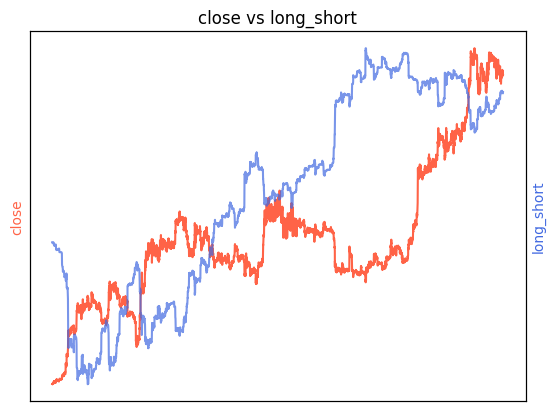

In [13]:
# long_liquidations와 short_liquidations의 차에 cumsum()을 적용한 데이터를 비교한 결과, close와 거의 완벽하게 반대로 움직인다.
eda_df['long_short'] = eda_df['long_liquidations'] - eda_df['short_liquidations']
eda_df['long_short'] = eda_df['long_short'].cumsum()

fig, ax1 = plt.subplots()
double_plot(data=eda_df, lefty='close', righty='long_short', leftax=ax1, rightalpha=0.7)
plt.title('close vs long_short')
plt.show()

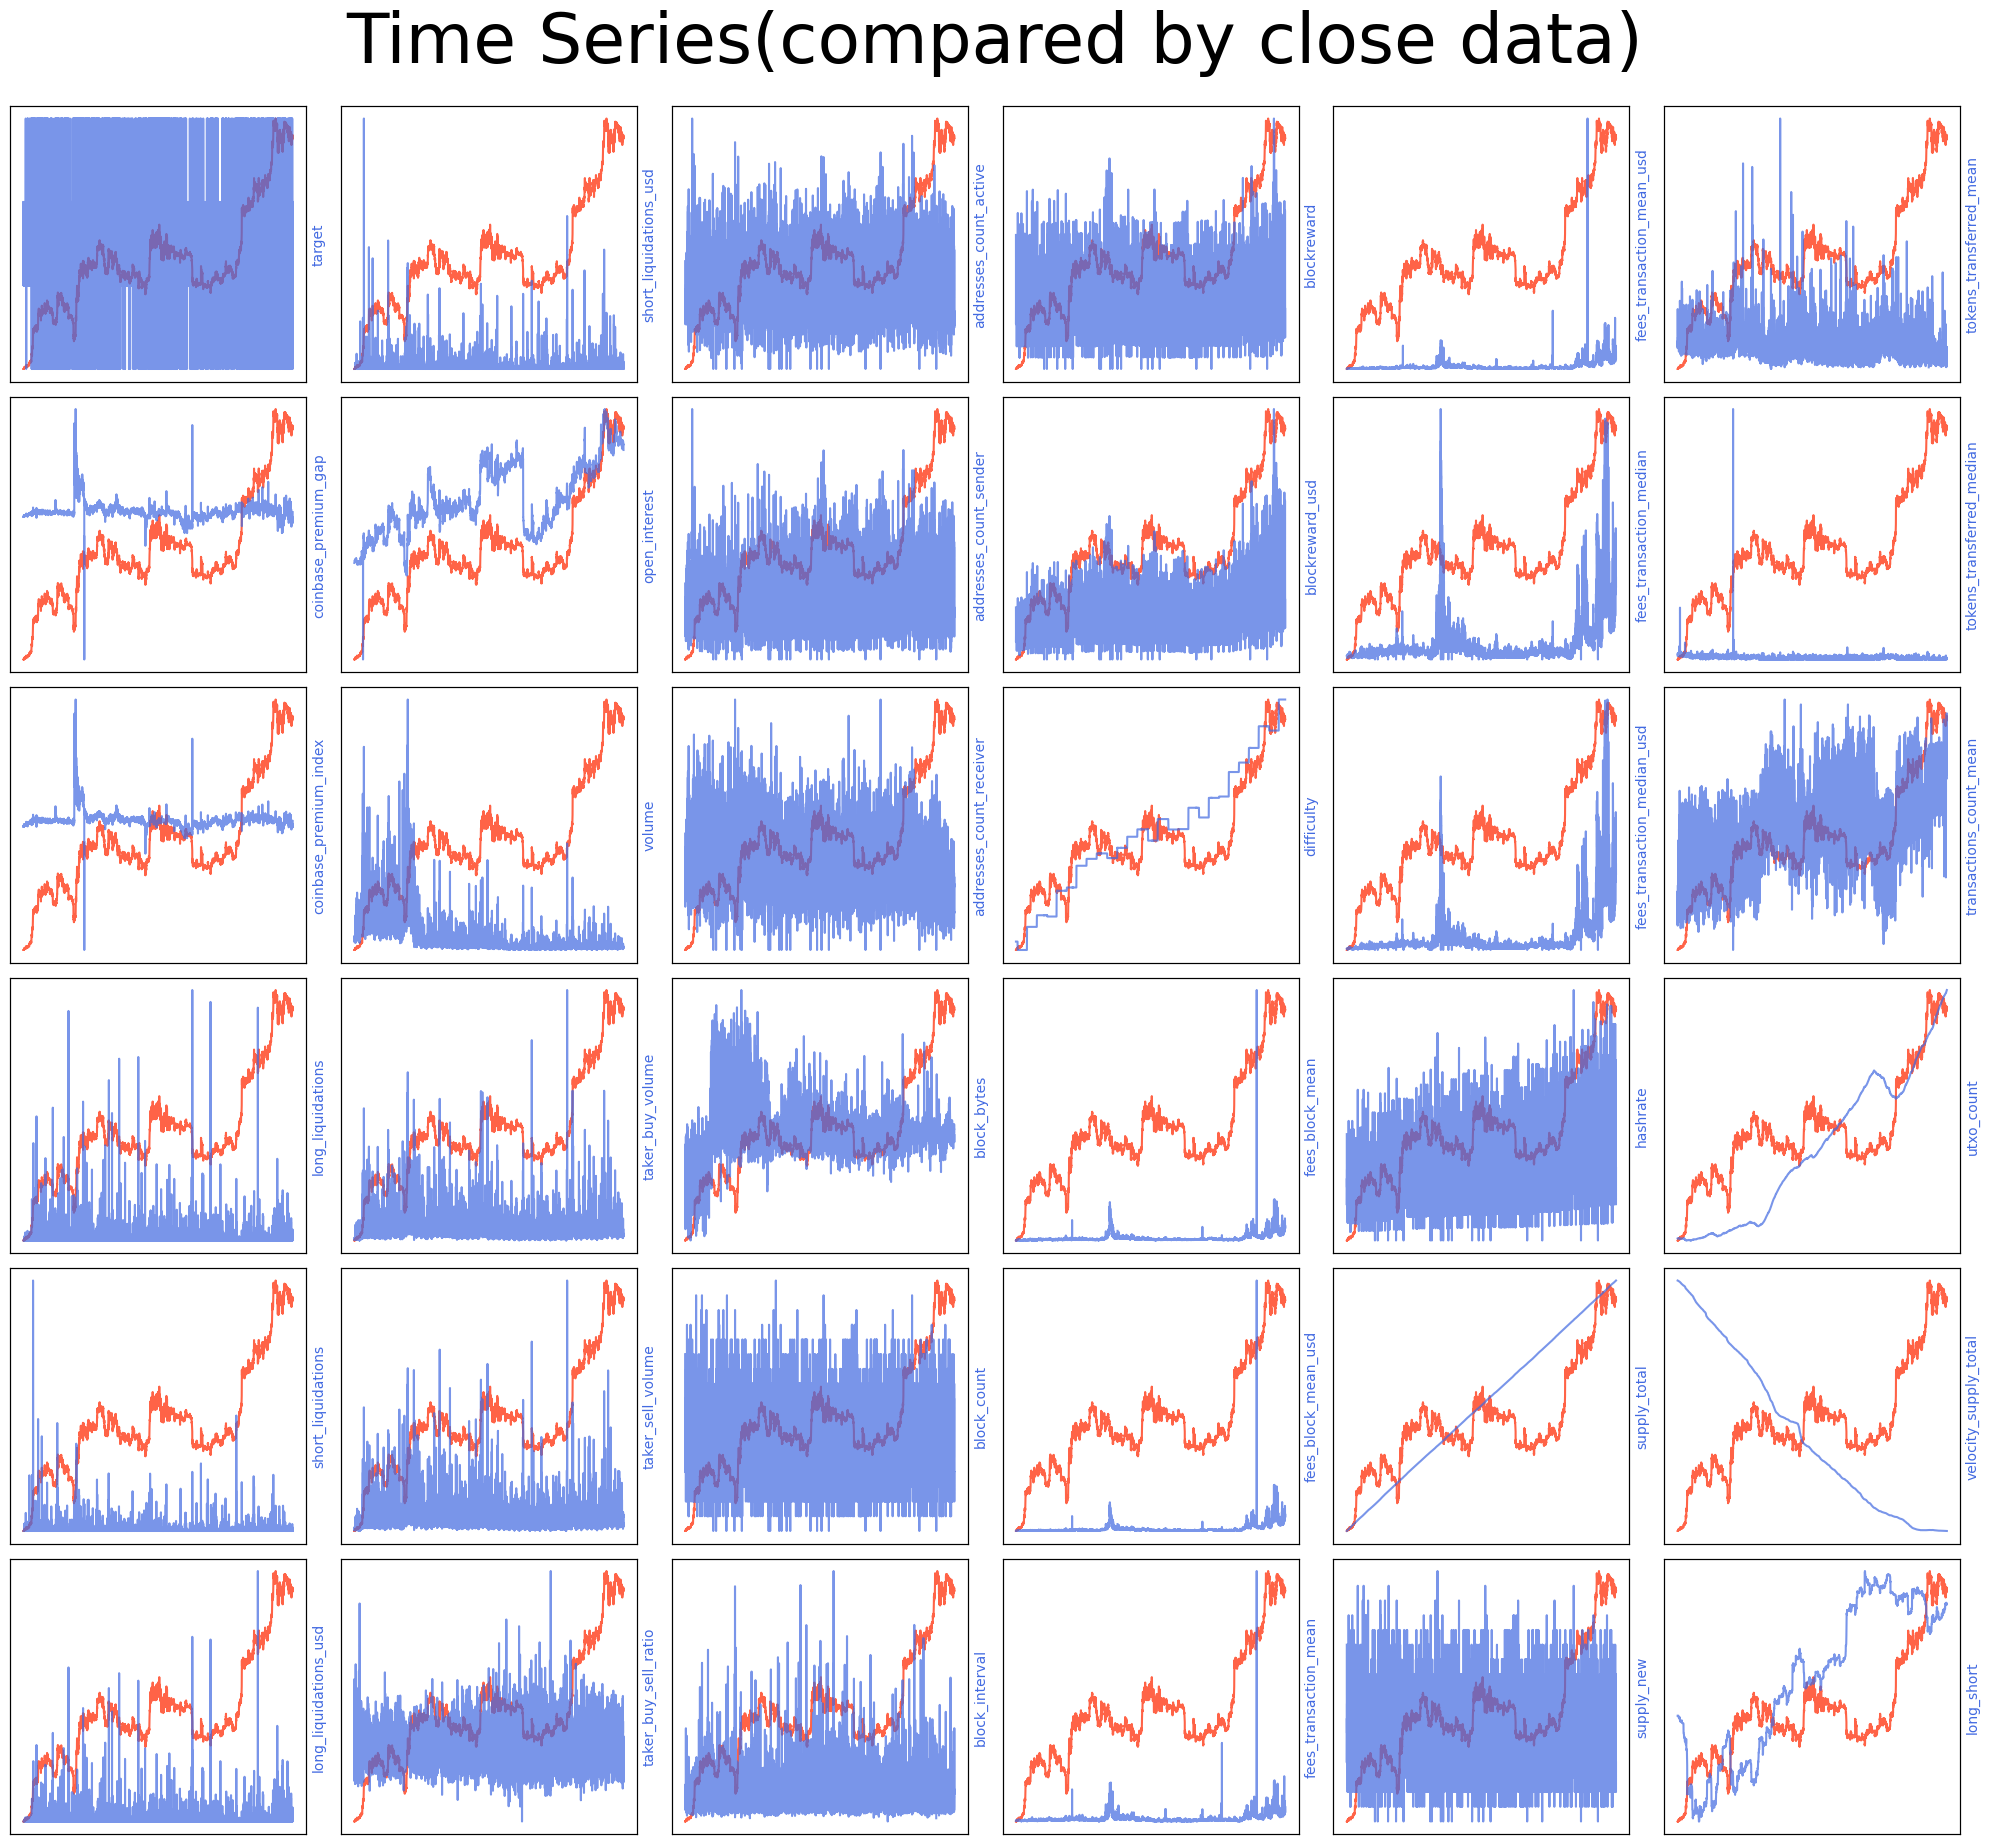

In [17]:
fig, axs = plt.subplots(6, 6, figsize=(20, 20))

for i, feature in enumerate(eda_df.drop(['ID', 'close'], axis=1).columns):
    double_plot(data=eda_df, lefty='close', righty=feature, leftax=axs[i%6, i//6], rightalpha=0.7,
                leftlabel=False)

fig.suptitle('Time Series(compared by close data)', fontsize=50, y=0.95)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()